In [175]:
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from tqdm import tqdm
from glob import glob
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Add custom module path
module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import custom utilities and models
import seis_feature
from utils import apply_cosine_taper, butterworth_filter, resample_array
from neural_network_architectures import (
    QuakeXNet_1d, QuakeXNet_2d, SeismicCNN_1d, SeismicCNN_2d
)

from scipy import signal
import torch.nn.functional as F

import torch




## function for extracting spectrograms for 2D input
def extract_spectrograms(waveforms, fs, nperseg=256, overlap=0.5):
    """
    Computes spectrograms from input waveform data.

    Parameters:
    - waveforms (numpy.ndarray): Input waveform data of shape (batch, channels, time).
    - fs (int): Sampling frequency (Hz).
    - nperseg (int, optional): Length of each FFT segment. Default is 256.
    - overlap (float, optional): Fraction of segment overlap. Default is 0.5.

    Returns:
    - numpy.ndarray: Spectrogram data of shape (batch, channels, frequencies, time_segments).
    """
    noverlap = int(nperseg * overlap)  # Compute overlap in samples

    # Compute shape of one spectrogram to initialize array
    f, t, Sxx = signal.spectrogram(waveforms[0, 0], nperseg=nperseg, noverlap=noverlap, fs=fs)

    # Initialize array to store spectrograms
    spectrograms = np.zeros((waveforms.shape[0], waveforms.shape[1], len(f), len(t)))

    # Compute spectrograms for each waveform and channel
    for i in range(waveforms.shape[0]):  # Iterate over waveforms
        for j in range(waveforms.shape[1]):  # Iterate over channels
            _, _, Sxx = signal.spectrogram(waveforms[i, j], nperseg=nperseg, noverlap=noverlap, fs=fs)
            spectrograms[i, j] = Sxx  # Store computed spectrogram

    return spectrograms

In [176]:
client = Client('USGS')

# Define search parameters
start_time = UTCDateTime("2020-01-01")
end_time = UTCDateTime("2025-03-01")

# Fetch events
catalog = client.get_events(starttime=start_time, endtime=end_time, minmagnitude= 2, latitude = 46.750599, 
                            longitude = -121.809601, minradius = 0, maxradius = 0.7)

# Print event details
print(catalog)


85 Event(s) in Catalog:
2025-02-25T07:17:30.220000Z | +47.344, -122.257 | 2.27 ml | manual
2025-02-22T11:45:29.310000Z | +47.276, -122.142 | 3.41 ml | manual
...
2020-04-12T13:46:03.820000Z | +46.761, -121.915 | 2.63 ml | manual
2020-01-28T08:17:59.910000Z | +46.883, -121.937 | 2.14 ml | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'


## Downloading three component strong motion data

We will be downloading data from the only station equipped with strong motion accelerometers in the mount rainier - UW.LON, three minutes of the data from the origin time of each event will be downloaded. 

In [177]:
# Initialize FDSN client (e.g., IRIS or specific provider)
client = Client("IRIS")

# Define station details
network = "UW"        # Network code
station = "LON"       # Station code
location = "*"        # Location code (wildcard for any)
channel = "*N*"       # Wildcard to match three-component strong motion channels

# Loop through each event in the catalog
for i, event in tqdm(enumerate(catalog)):
    origin_time = event.origins[0].time  # Get the origin time

    # Define start and end times (3-minute duration)
    start_time = origin_time
    end_time = origin_time + 180  # 180 seconds = 3 minutes

    try:
        # Request waveform data
        st = client.get_waveforms(network, station, location, channel, start_time, end_time)

        # Save waveform data to MSEED format
        filename = f"../data/strong_motion_data/event_{i}_{origin_time.strftime('%Y%m%d%H%M%S')}_UW_LON.mseed"
        st.write(filename, format="MSEED")

        #print(f"Saved: {filename}")

    except Exception as e:
        print(f"Failed to download data for event at {origin_time}: {e}")

45it [00:33,  1.41it/s]

Failed to download data for event at 2022-12-23T07:02:07.610000Z: No data available for request.
HTTP Status code: 204
Detailed response of server:




64it [00:47,  1.54it/s]

Failed to download data for event at 2021-11-26T23:57:01.190000Z: No data available for request.
HTTP Status code: 204
Detailed response of server:




85it [01:03,  1.35it/s]


## Processing the downloaded data

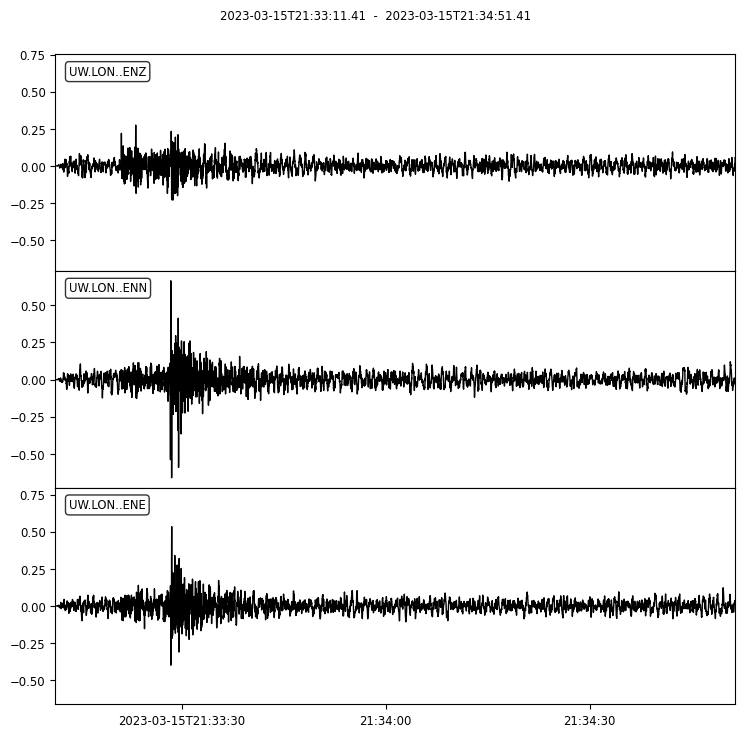

In [178]:
w_files = glob('../data/strong_motion_data/*')
st = obspy.read(w_files[40]).select(channel = 'EN*')

st.detrend('demean').detrend('linear').taper(0.01).filter('bandpass', freqmin = 1, freqmax = 20).integrate().trim(st[0].stats.starttime, st[0].stats.starttime+100).plot();

In [187]:
evids = []
data = []
w_files = glob('../data/strong_motion_data/*')
for i in range(len(w_files)):
    st = obspy.read(w_files[i]).select(channel = 'EN*')

    if len(st) == 3:
        data.append(np.array(st.detrend('demean').detrend('linear').taper(0.01).filter('bandpass', freqmin = 1, freqmax = 20).integrate().trim(st[0].stats.starttime, st[0].stats.starttime+100).resample(50)[0:5000]))
        evids.append(int(w_files[i].split('_')[3]))
data = np.array(data)

In [188]:
taper_alpha = 0.1
lowcut = 1
highcut = 20
nyquist = 0.5 * 50  # Nyquist frequency (original sampling rate is 100 Hz)
low = lowcut / nyquist
high = highcut / nyquist
b, a = signal.butter(4, [low, high], btype='band') 

tapered_data = np.array([np.multiply(signal.windows.tukey(data.shape[-1], alpha=taper_alpha), row) for row in data])
filtered_data = np.array([signal.filtfilt(b, a, row) for row in tapered_data])
norm = np.std(abs(filtered_data), axis=2)
normalized_data = (filtered_data / norm[:, :, None])


In [189]:
specs = extract_spectrograms(normalized_data, fs = 50)

## Glancing over few waveforms indicate that waveforms are fairly good snr

## Loading the machine learning models

Ignore the warnings here

In [190]:
# ====================
# 1. Model Setup Parameters
# ====================
# Fixed parameters for the models (do not change)
num_channels = 3        # Number of input channels (seismic data)
dropout = 0.9           # Dropout rate to prevent overfitting

# Set device to GPU if available, else use CPU
device = "cpu"     #torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# 2. Model Initialization
# ============================
# Initialize models with the number of classes, channels, and dropout rate
model_seismiccnn_1d = SeismicCNN_1d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_seismiccnn_2d = SeismicCNN_2d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_quakexnet_1d = QuakeXNet_1d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_quakexnet_2d = QuakeXNet_2d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)

# ============================
# 3. Load Pretrained Weights
# ============================
# Load the pretrained model state dictionaries from saved files
saved_model_seismiccnn_2d = torch.load('../trained_deep_learning_models/best_model_SeismicCNN_2d.pth', map_location=device)
saved_model_quakexnet_2d = torch.load('../trained_deep_learning_models/best_model_QuakeXNet_2d.pth', map_location=device)
saved_model_quakexnet_1d = torch.load('../trained_deep_learning_models/best_model_QuakeXNet_1d.pth', map_location=device)
saved_model_seismiccnn_1d = torch.load('../trained_deep_learning_models/best_model_SeismicCNN_1d.pth', map_location=device)

# ============================
# 4. Load Weights into Models
# ============================
# Load the state dictionaries into the corresponding models
model_seismiccnn_1d.load_state_dict(saved_model_seismiccnn_1d)
model_seismiccnn_2d.load_state_dict(saved_model_seismiccnn_2d)
model_quakexnet_1d.load_state_dict(saved_model_quakexnet_1d)
model_quakexnet_2d.load_state_dict(saved_model_quakexnet_2d)


# ============================
# 5. Set Models to Evaluation Mode
# ============================
# Move models to evaluation mode (important for layers like dropout and batch norm)
model_seismiccnn_1d.eval()
model_seismiccnn_2d.eval()
model_quakexnet_1d.eval()
model_quakexnet_2d.eval()

# ============================
# 6. Move Models to Correct Device
# ============================
# Ensure all models are on the correct device (GPU or CPU)
model_seismiccnn_1d.to(device)
model_seismiccnn_2d.to(device)
model_quakexnet_1d.to(device)
model_quakexnet_2d.to(device)


/tmp/ipykernel_53877/2063820159.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model_seismiccnn_2d = torch.load('../trained_deep_learning_models/best_model_Seism

QuakeXNet_2d(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): Bat

In [191]:
np.argmax(softmax_probs, axis = 1)

array([0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0])

In [192]:
model = model_quakexnet_2d
# Run classification
with torch.no_grad():
    output = model(torch.Tensor(specs))
    softmax_probs = F.softmax(output, dim=1).cpu().numpy()

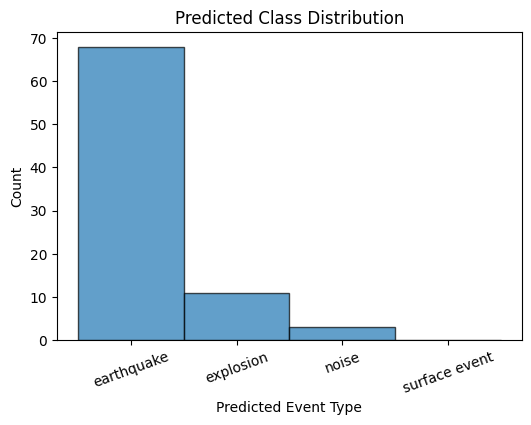

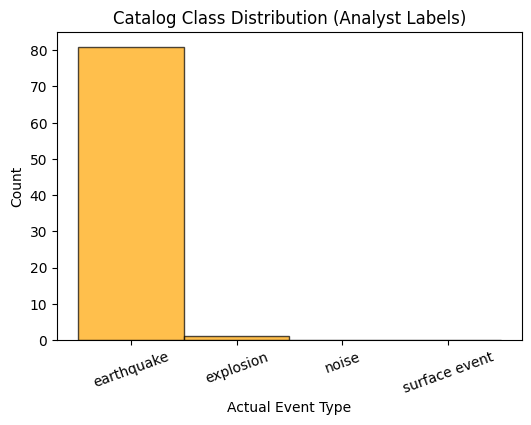

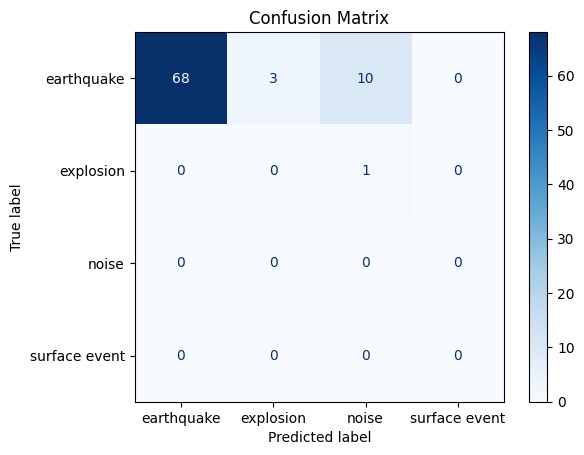

Classification Accuracy: 82.93%


In [211]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Define class labels
class_labels = np.array(["earthquake", "explosion", "noise", "surface event"])

# Get predicted labels
predicted_labels = np.argmax(softmax_probs, axis=1)
predicted_categories = class_labels[predicted_labels]

# Get actual labels from catalog
actual_categories = np.array([catalog[evid].event_type for evid in evids])

# Compute classification accuracy
accuracy = accuracy_score(actual_categories, predicted_categories)

# Plot histogram of predicted labels
plt.figure(figsize=(6,4))
plt.hist(predicted_categories, bins=np.arange(len(class_labels)+1)-0.5, edgecolor="black", alpha=0.7)
plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels, rotation=20)
plt.xlabel("Predicted Event Type")
plt.ylabel("Count")
plt.title("Predicted Class Distribution")
plt.show()

# Plot histogram of actual labels from the catalog
plt.figure(figsize=(6,4))
plt.hist(actual_categories, bins=np.arange(len(class_labels)+1)-0.5, edgecolor="black", alpha=0.7, color="orange")
plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels, rotation=20)
plt.xlabel("Actual Event Type")
plt.ylabel("Count")
plt.title("Catalog Class Distribution (Analyst Labels)")
plt.show()

# Display Confusion Matrix
conf_matrix = confusion_matrix(actual_categories, predicted_categories, labels=class_labels)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

# Print accuracy
print(f"Classification Accuracy: {accuracy:.2%}")
